In [1]:
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit, execute
from qiskit import Aer
from qiskit.providers.aer import AerSimulator

from qiskit.visualization import plot_histogram
import copy, random, itertools
import qiskit.providers.aer.noise as noise
from qiskit.quantum_info.analysis import hellinger_fidelity

In [2]:
# noise model for four-general problem
# the errors are the averages reported from the real device ibmq-sydney
biz_noise_model = noise.NoiseModel()

# Error probabilities 
prob_1 = 0.0005  # 1-qubit gate
prob_2 =  0.013  # 2-qubit gate
Er0 =  0.075   # readout error P("1"|"0")
Er1 =  0.11   # readout error P("0"|"1")

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

biz_noise_model.add_all_qubit_quantum_error(error_1, ['rz', 'sx', 'x'], warnings=False)
biz_noise_model.add_all_qubit_quantum_error(error_2, ['cx0'] , warnings=False)
biz_noise_model.add_all_qubit_readout_error([[1 - Er0, Er0], [Er1, 1 - Er1]])

print(biz_noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u3', 'x']
  Instructions with noise: ['cx0', 'x', 'measure', 'rz', 'sx']
  All-qubits errors: ['rz', 'sx', 'x', 'cx0', 'measure']


In [3]:
# parameters
noise = True
simulator = Aer.get_backend('qasm_simulator')
optimization_level = 2
shots = 2**13
max_rounds = 500
verbose_flag = False

# number of generals
N_gen = 4

# here you can change the backends
from qiskit.test.mock import FakeCasablanca as device_3_generals
from qiskit.test.mock import FakeSydney as device_4_generals

In [4]:
# adapt to given parameters
if N_gen == 3:
    perms = list(itertools.permutations(['00','01','10'], r=3))
    device = device_3_generals
    noise_model = None
elif N_gen == 4:
    perms = list(itertools.permutations(['00','01','10','11'], r=4))
    device = device_4_generals
    noise_model = biz_noise_model
else: 
    print("only the three and four generals cases considered at this time")

if noise:
    backend = AerSimulator.from_backend(device())
else: # switch to the ideal device
    backend = simulator

In [5]:
# set device dependant parameter for final agreement algorithm
noise_dic = {'qasm_simulator' : 0.0, 
             'aer_simulator(fake_casablanca)' : 0.05, 
             'aer_simulator(fake_guadalupe)' : 0.1,
             'aer_simulator(fake_sydney)' : 0.12,
             'aer_simulator(fake_montreal)' : 0.15,
            }

In [6]:
# use the simulator to get get the bitstring list
circuit = QuantumCircuit(2 * N_gen)
circuit.h(circuit.qubits)

circuit.measure_active()

job = execute(circuit, backend = simulator,shots = 2**13)
              
result = job.result()
counts = result.get_counts(circuit)

bitstrings = np.sort(list(counts.keys()))
nonorm_init_list= []

for bitstring in bitstrings:
    flag = 0
    for perm in perms:
        if bitstring == ''.join(list(perm)):
            flag = 1
            #break    
    nonorm_init_list.append(flag)

init_list = np.array(nonorm_init_list) / np.sqrt(np.math.factorial(N_gen))

In [7]:
# code used to prepare the equation for the states in the following text
bstring_list = []

for perm in perms:
        bstring_list.append(''.join(list(perm)))

state_N_gen = "("
for bstring in bstring_list:
    state_N_gen += '|' + ''.join(list(bstring)) + "\rangle +  "
state_N_gen = state_N_gen[:-1] + ")"

#### Prepare the state:


In case of three generals:

$$(|000110\rangle +  |001001\rangle +  |010010\rangle +  |011000\rangle +  |100001\rangle +  |100100\rangle) /\sqrt!3$$


In case of four generals:


$$(|00011011\rangle +  |00011110\rangle +  |00100111\rangle +  |00101101\rangle +  |00110110\rangle +  |00111001\rangle +  |01001011\rangle +  |01001110\rangle +  |01100011\rangle +  |01101100\rangle +  |01110010\rangle +  |01111000\rangle +  |10000111 \rangle +  |10001101\rangle +  |10010011\rangle +  |10011100\rangle +  |10110001\rangle +  |10110100\rangle +  |11000110\rangle +  |11001001\rangle +  |11010010\rangle +  |11011000\rangle +  |11100001\rangle +  |11100100\rangle) \ /\sqrt!4$$

In [8]:
# create the quantum circuit
circuit = QuantumCircuit(2 * N_gen)

circuit.initialize(init_list, circuit.qubits)

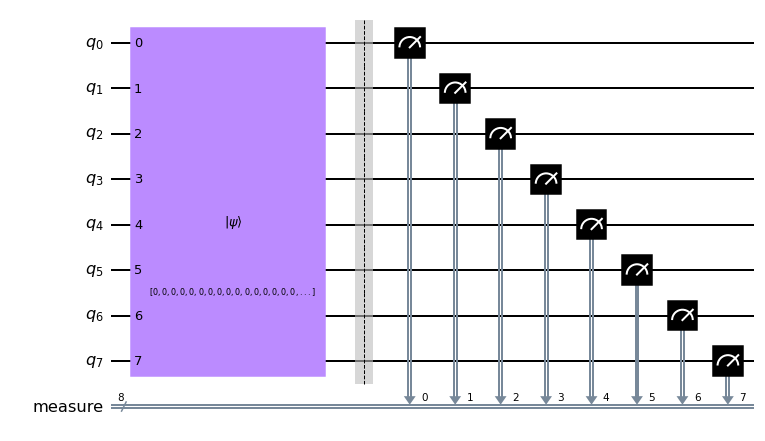

In [9]:
# add Pauli-Z measurements and draw the circuit
circuit.measure_active()
circuit.draw(output='mpl')

In [10]:
# if more details are requested (more .decompose() may be added)
#qasm_circuit = circuit.decompose().decompose() 
#qasm_circuit.draw(output='mpl', fold = 20 - N_gen , plot_barriers=False,
                  #style = {'backgroundcolor': 'cyan'})                                             

## game functions

In [11]:
# byzantine traitor game serving function
def serve(k_list, t_list, n_its_list, used_list, stop_flag):
    flag_1 = True
    flag_2 = True
    
    retry = True
    while retry:
        k = k_list[-1]
        if k in used_list:
            k_list.pop()
            if k_list == []: 
                stop_flag = True
                return flag_1, flag_2
        else:
            retry = False
            used_list.append(k)
    
    if k in t_list:
        flag_1 = False

    if n_its_list[k] < 2:
        flag_2 = False

    return flag_1, flag_2

In [12]:
def traitor_game(players, verbose = False):
    # start playing
    
    game_rounds = 0
    toss = random.randrange(2)
    head = tail = 0
    gen[players[toss]]['failed'] = 0
    gen[players[1-toss]]['failed'] = 0
    
    mat_t = gen[players[toss]]['mat']
    n_its_toss = n_its[mat_t:mat_t+1][0]
    mat_nt = gen[players[1-toss]]['mat']
    n_its_notoss = n_its[mat_nt:mat_nt+1][0]
    
    flag = np.ones((2, 2), dtype=bool)
    used_list = []
    stop_flag = False
    print("\nByzantine traitor game. First to serve is", gen[players[toss]]['name'])
    print("                        Second to serve is", gen[players[1-toss]]['name'])    
    
    if verbose:
        print( "shots:", shots )
        print(len(gen[players[toss]]['k_list']), "in "  + gen[players[toss]]['name'] + ' list:', 
                   sorted(gen[players[toss]]['k_list']) )   
        print(len(gen[players[1-toss]]['k_list']), "in "  + gen[players[1-toss]]['name'] + ' list:', 
                   sorted(gen[players[1-toss]]['k_list']) )    
    
    while len(gen[players[toss]]['k_list']) > 0 and game_rounds < max_rounds\
            and len(gen[players[1-toss]]['k_list']) > 0 and not stop_flag:
        
        game_rounds += 1        
        
        # first to serve
        flag[0][1], flag[1][1] = serve(gen[players[toss]]['k_list'],
                                   gen[players[1-toss]]['t_list'],
                                   n_its_notoss, used_list, stop_flag)
        
        if not flag[0][1] or not flag[1][1]:                          
            head +=1
        
        gen[players[toss]]['k_list'].pop()

        # second to serve
        if not stop_flag: 
            
            flag[0][0], flag[1][0] = serve(gen[players[1-toss]]['k_list'],
                                       gen[players[toss]]['t_list'],
                                       n_its_toss, used_list, stop_flag)

            if not flag[0][0] or not flag[1][0]:                                     
                tail += 1

            gen[players[1-toss]]['k_list'].pop()    
    
    if verbose:
        print(len(used_list), "ind in used_list", sorted(used_list) ) 
    
    print("rounds:", game_rounds)
    
    print(gen[players[1-toss]]['name'] + " counted that " +\
           gen[players[toss]]['name'] + " failed " + str(head)\
           + " times: " + "{:.0%}".format(head / game_rounds))
              
    
    print(gen[players[toss]]['name'] + " counted that " +\
           gen[players[1-toss]]['name'] + " failed " + str(tail)\
           + " times: " + "{:.0%}".format(tail / game_rounds))
    
    return game_rounds, head, tail, toss

## Start experiments
### distribute entaglement

In [13]:
# distribute entanglement 
if noise:
    job_ideal = execute(circuit, backend = simulator, shots = shots,                
                optimization_level = optimization_level)
    
    res_ideal = job_ideal.result()
    counts_ideal = res_ideal.get_counts(circuit)

    if shots <= 200: # for checks
        verbose_flag = True

    if N_gen == 3:    
        job = execute(circuit, backend = backend, shots = shots,
        memory=True,     
        optimization_level = optimization_level)
        figsize = (16,7)
        
    elif N_gen == 4:
        job = execute(circuit, backend = backend, shots = shots,
        noise_model = noise_model,
        memory=True,
        optimization_level = optimization_level)
        figsize = (100,30) 
   
    else: 
        job = None
        print("only the three and four generals cases considered at this time")

    results = job.result()
    memory = results.get_memory(circuit)
    counts = results.get_counts(circuit)
    legend_to_plot = [simulator, backend.name()]
    counts_to_plot = [counts_ideal,counts]
    print('hellinger fidelity: {:.1%}'.format(
        hellinger_fidelity(counts_ideal,counts)))
else:
    job_ideal = execute(circuit, backend = simulator, shots = shots,
                        memory = True,
                        optimization_level = optimization_level)
    results = job_ideal.result()
    memory = results.get_memory(circuit)
    counts = results.get_counts(circuit)
    legend_to_plot = [backend.name()]
    counts_to_plot = [counts]
    figsize = None

hellinger fidelity: 42.6%


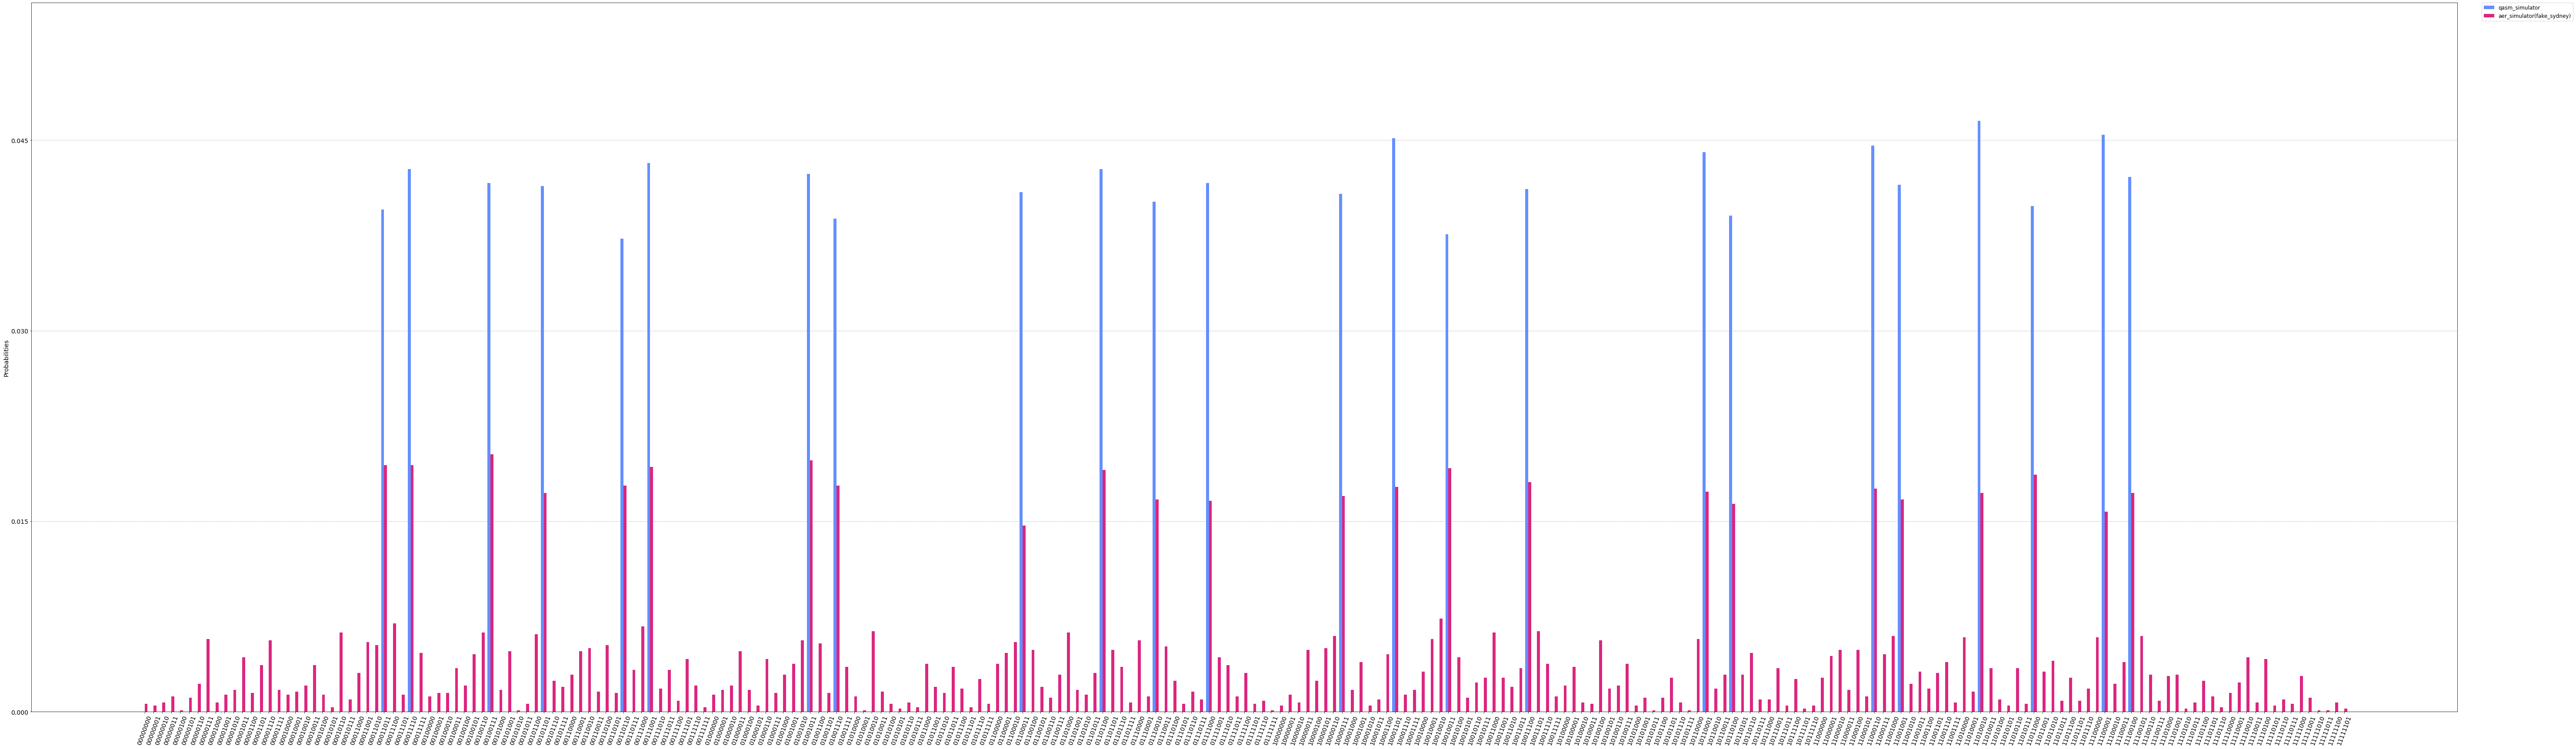

In [14]:
plot_histogram(counts_to_plot, bar_labels = False,
                   figsize = figsize,
                   legend = legend_to_plot)

In [15]:
# get an array of shape((N_gen,shots))
n_its = np.zeros((N_gen,shots)).astype(int)

# convert bitstrings to n_its and store them 
# '00'--> 2  '01'--> 1  '10'--> 0  '11' --> 3
n_it_vals = [2, 1, 0, 3]

for j, bitstring in enumerate(memory):
    for pos in range(N_gen):
        n_its[pos][j] = n_it_vals[int(bitstring[2*pos:2*pos+2],2)]

###   check if the entangled states are not corrupt

Mutual verification that no n_it value of a list occupies the same place in one of the other lists.

Here it is not simulated because not really relevant for the demonstration.

### use the results to solve the problem

In [19]:
# define scenario
gen = { 'A': { "mat" : 0, 'name': 'Alice', 'faithful': False, 'target': None},
        'B': { "mat" : 1, 'name': 'Bob', 'faithful': True, 'target': False},
        'C': { "mat" : 2, 'name': 'Charlie', 'faithful': True, 'target': True} }
if N_gen == 4 :       
        gen['D'] = { "mat" : 3,'name': 'Dave', 'faithful': False, 'target': False} 

In [20]:
# check here the number of traitors
 
for key in list(gen.keys())[1:N_gen]:
    if not gen[key]['faithful'] and gen[key]['target']:           
        print("A lieutenant cannot be traitor himself and target of a traitorous commander") 
        print("Please correct the scenario")

traitor_counter = 0
for key in list(gen.keys())[0:N_gen]:    
    if not gen[key]['faithful']:
        traitor_counter += 1

print("Scenario with " + str(N_gen) + " generals and " + str(traitor_counter) + " traitor(s)")

if traitor_counter > N_gen -2 :
    print("No more than " + str(N_gen-2) + " traitor(s) allowed for "\
          + str(N_gen) + " generals, even with quantum power") 
    print("Please correct the scenario")    

Scenario with 4 generals and 2 traitor(s)


In [21]:
print("Scenario run on " + backend.name())
print("generals:", list(map(lambda v: v["name"],gen.values()))[0:N_gen])
print("faithful:  ", list(map(lambda v: v["faithful"],gen.values()))[0:N_gen])
print("  target:  ", list(map(lambda v: v["target"],gen.values()))[0:N_gen])

# Alice determine the message: 0 for retreat, 1 for attack
m = 0
gen['A']['message'] = m
# Alice establishes the corresponding list of indices 
# and the corresponding cheating list

j_list_A = []
j_list_Ac = []
mat = gen['A']['mat']
for k in range(shots):
    val_it = n_its[mat:mat+1][0][k]
    if val_it == m:
        j_list_A.append(k)
    elif val_it == 1 - m:
        j_list_Ac.append(k)

# Alice send her messages and corresponding lists 
# by pairwise authenticated classical and quantum channels  

# first equalize lists lengths

random.shuffle(j_list_A)
while len(j_list_A) > len(j_list_Ac):
    j_list_A.pop()
j_list_A.sort()
random.shuffle(j_list_Ac)
while len(j_list_Ac) > len(j_list_A):
    j_list_Ac.pop()
j_list_Ac.sort()
gen['A']['j_list'] = copy.deepcopy(j_list_A) 

for key in list(gen.keys())[1:N_gen]:
    if (not gen['A']['faithful']) and gen[key]['target']:
        gen[key]['message'] = 1 - m    
        gen[key]['j_list'] = copy.deepcopy(j_list_Ac )
    else:
        gen[key]['message'] = m    
        gen[key]['j_list'] = copy.deepcopy(j_list_A) 
            
# test of consistency by the lieutenants (compare j_list and message)
for key in list(gen.keys())[1:N_gen]:
    gen[key]['flag_y'] = gen[key]['message']

# false flag by traitors:
for key in list(gen.keys())[1:N_gen]:
    if gen[key]['faithful']:
        gen[key]['t_list'] = copy.deepcopy(gen[key]['j_list'])
    else:
        gen[key]['flag_y'] = 1 - gen[key]['flag_y']
        gen[key]['t_list'] = list( set(range(shots)) - set(gen[key]['j_list']) )

# prepare for treator game

p_list = []
    
for key in list(gen.keys())[1:N_gen]:

    # add to player's list:            
    if gen[key]['flag_y'] != 3: 
        p_list.append(key)

# check if treator game possible
if len(p_list) == 1:
    print("Only one lieutenant has consistent order") 

elif len(p_list) == 0:
    print("No lieutenant has consistent order")
    
else: # treator game:
        
    res_traitor = {}
    
    for players in list(itertools.combinations(p_list, r=2)):
        
        if gen[players[0]]['flag_y'] == gen[players[1]]['flag_y']:
            print("\nNo game between " + gen[players[0]]['name']\
             + " and " + gen[players[1]]['name'] + "\nThey say they got the same order from " + gen['A']['name'])
            res_traitor[players[0] + players[1]] = -1.0
            res_traitor[players[1] + players[0]] = -1.0
        
        else:
            # prepare indices list
            for key in players:
                gen[key]['k_list'] = []                        
                mat = gen[key]['mat']
                
                for k in range(shots):
                    n_it = n_its[mat:mat+1][0][k]
                    if (k in gen[key]['t_list']) and (n_it == 1 - gen[key]['flag_y']):
                        gen[key]['k_list'].append(k)    

                    random.shuffle(gen[key]['k_list'])
                
            game_rounds, head, tail, toss = traitor_game(players, verbose_flag)
            res_traitor[players[1-toss] + players[toss]] = head / game_rounds
            res_traitor[players[toss] + players[1-toss]] = tail / game_rounds    
                
    print("\nFinal agreement:\n")
    
    sorted_res = dict(sorted(res_traitor.items()))
    res_val = list(sorted_res.values())
    test_val = np.round(np.array(res_val) + noise_dic[backend.name()])
        
    if N_gen == 3 :  # three generals with traitor game
                
        if np.sum(test_val) == - 2:
            print("No traitor detected")
            print("Both lieutenants follow the order of ", gen['A']['name'])
    
        elif np.sum(test_val) == 0:
            print(gen['A']['name'] + " is a traitor")
            print(gen['B']['name'] + " and " + gen['C']['name'] + " agree with a common strategy")        
        
        elif test_val[0] == [1.] and test_val[1] == [0.]:
            print(gen['C']['name'] + " is a traitor")
            print(gen['B']['name'] + " follows the order of " +  gen['A']['name'])
        
        elif test_val[0] == [0.] and test_val[1] == [1.]:
            print(gen['B']['name'] + " is a traitor")
            print(gen['C']['name'] + " follows the order of " +  gen['A']['name'])
            
        else:
            print("Something wrong")

    if N_gen == 4 :  # four generals with traitor game
        
        if np.sum(test_val) == - 6:
            print("No traitor detected")
            print("All lieutenants follow "+ gen['A']['name'] +"'s order")
        else:
            uncovered = []
            discoverer = []

            for i, (j, k) in enumerate(sorted_res):
    
                if test_val[i] == 1.0:
                    uncovered.append(gen[k]['name'])
                    discoverer.append(gen[j]['name'])

            if np.sum(test_val) == -2 and len(uncovered) == 0:
                print("The commanding general is a traitor")
                print("All lieutenants follow a majority strategy") 

            elif np.sum(test_val) == 0 and len(uncovered) == 2:

                if uncovered[0] != uncovered[1]:
                    print(uncovered[0]+" and "+uncovered[1]+" are traitors")
                    print(discoverer[0]+" follows "+ gen['A']['name'] +"'s order")
                else:
                    print(uncovered[0]+" is a traitor")
                    print(discoverer[0]+" and "+discoverer[1]+" follow "+ gen['A']['name'] +"'s order")

            elif np.sum(test_val) == -1 and len(uncovered) == 1:
                    print(uncovered[0]+" and "+ gen['A']['name'] +" are traitors")

                    # who was the targed of the traitor?
                    for key in list(gen.keys())[1:N_gen]:
                        if gen[key]['name'] != uncovered[0] and gen[key]['name'] != discoverer[0]:
                            t_target = gen[key]['name'] 

                    print(discoverer[0] +" and "+ t_target +" agree with a common strategy")
            else:
                print("Something wrong")

Scenario run on aer_simulator(fake_sydney)
generals: ['Alice', 'Bob', 'Charlie', 'Dave']
faithful:   [False, True, True, False]
  target:   [None, False, True, False]

Byzantine traitor game. First to serve is Bob
                        Second to serve is Charlie
rounds: 500
Charlie counted that Bob failed 136 times: 27%
Bob counted that Charlie failed 149 times: 30%

Byzantine traitor game. First to serve is Dave
                        Second to serve is Bob
rounds: 500
Bob counted that Dave failed 218 times: 44%
Dave counted that Bob failed 180 times: 36%

No game between Charlie and Dave
They say they got the same order from Alice

Final agreement:

Dave and Alice are traitors
Bob and Charlie agree with a common strategy
